In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

2024-06-09 18:07:56.661129: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-09 18:07:56.661229: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-09 18:07:56.802583: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 299
CHANNELS=3
EPOCHS=100


In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/full-classes/Full Data Class",
    seed=72,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1808 files belonging to 12 classes.


In [4]:
# val_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     "/kaggle/input/new-dataset/dataset/val150",
#     seed=74,
#     shuffle=True,
#     image_size=(IMAGE_SIZE,IMAGE_SIZE),
#     batch_size=BATCH_SIZE
# )

In [5]:
# test_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     "/kaggle/input/new-dataset/dataset/test150",
#     seed=74,
#     shuffle=True,
#     image_size=(IMAGE_SIZE,IMAGE_SIZE),
#     batch_size=BATCH_SIZE
# )

In [6]:
# number of class 

class_names = dataset.class_names
class_names

['Abnormal',
 'Erythrodermic',
 'Guttate',
 'Inverse',
 'Nail',
 'Normal',
 'Not Define',
 'Palm Soles',
 'Plaque',
 'Psoriatic Arthritis',
 'Pustular',
 'Scalp']

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 299, 299, 3)
[ 0  0  0  5  7  0  0 10 11  6  0  0  1  3  7  6  5  8  3  3  1 11  0  6
  1  0  0  7  5  0  0 10]


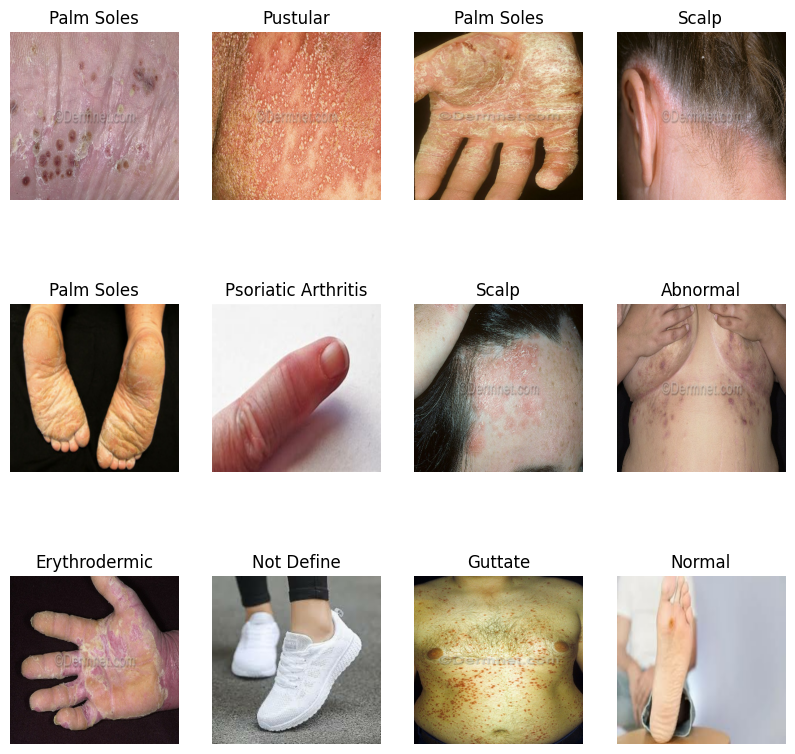

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
len(dataset)

57

In [10]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [12]:
len(train_ds),len(val_ds),len(test_ds)

(45, 5, 7)

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [15]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [34]:
from keras import layers, models
from keras.applications import Xception

# Assuming resize_and_rescale and data_augmentation are defined elsewhere

BATCH_SIZE = 32
IMAGE_SIZE = 299
CHANNELS = 3
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 12

# Load VGG19 model with imagenet weights
vgg_model = Xception(
    include_top=False,  # Exclude the fully-connected layers at the top
    weights='imagenet',
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
)

# Freeze the VGG19 layers
for layer in vgg_model.layers[:-25]:
    layer.trainable = False

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    vgg_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


In [35]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 299, 299, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 299, 299, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (32, 10, 10, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 204800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 128)              │    26,214,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 12)               │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,077,556 (179.59 MB)

 Trainable params: 34,618,436 (132.06 MB)

 Non-trainable params: 12,459,120 (47.53 MB)

In [36]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [37]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=100,
)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 273ms/step - accuracy: 0.1472 - loss: 6.6422 - val_accuracy: 0.2250 - val_loss: 2.2355
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 249ms/step - accuracy: 0.3222 - loss: 2.2503 - val_accuracy: 0.3125 - val_loss: 2.1963
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 248ms/step - accuracy: 0.3280 - loss: 2.2147 - val_accuracy: 0.3562 - val_loss: 2.1155
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 249ms/step - accuracy: 0.3710 - loss: 2.0934 - val_accuracy: 0.3625 - val_loss: 1.9407
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 249ms/step - accuracy: 0.4036 - loss: 1.9036 - val_accuracy: 0.3875 - val_loss: 1.8995
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 248ms/step - accuracy: 0.4258 - loss: 1.7943 - val_accuracy: 0.3938 - val_loss: 1.7731
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 249ms/step - accuracy: 0.4453 - loss: 1.6446 - val_accuracy: 0.3938 - val_loss: 1.6976
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 249ms/step - accuracy: 0.4737 - loss: 1.5318 - 

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

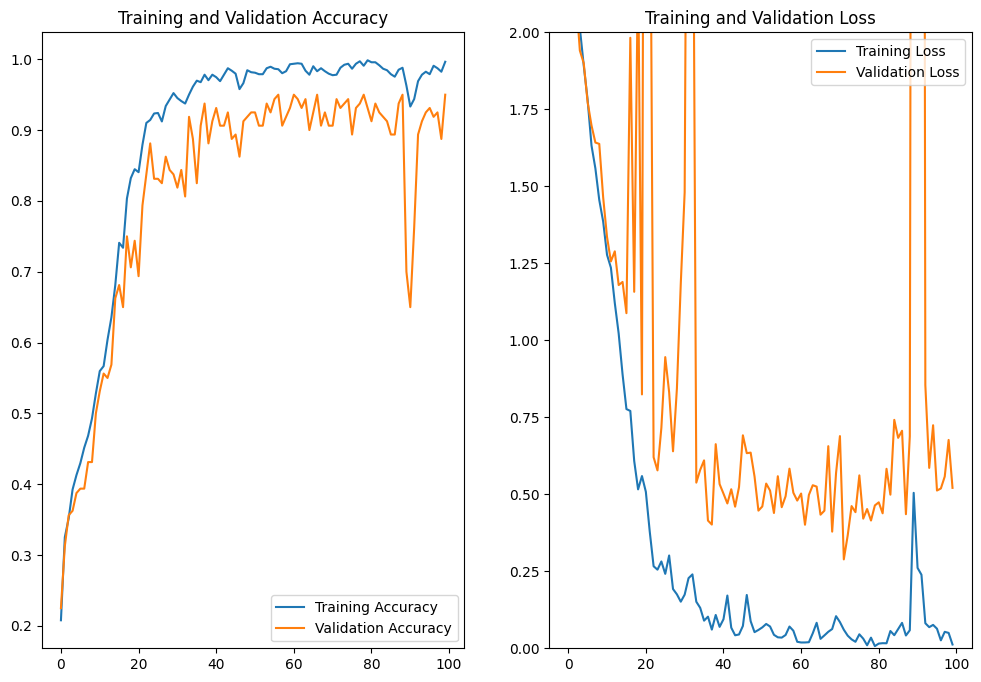

In [39]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(range(100), acc, label='Training Accuracy')
plt.plot(range(100), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(100), loss, label='Training Loss')
plt.plot(range(100), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylim( 0,2)  
plt.show()

In [40]:
scores = model.evaluate(test_ds)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.9533 - loss: 0.3401


first image to predict
actual label: Abnormal
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
predicted label: Abnormal


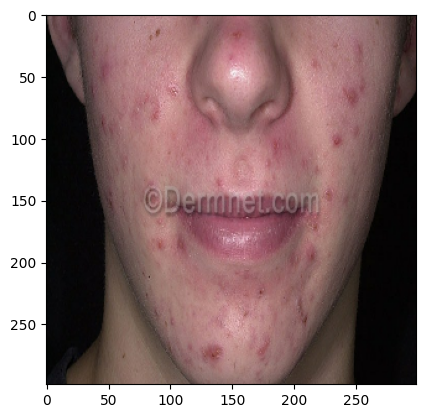

In [41]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [42]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


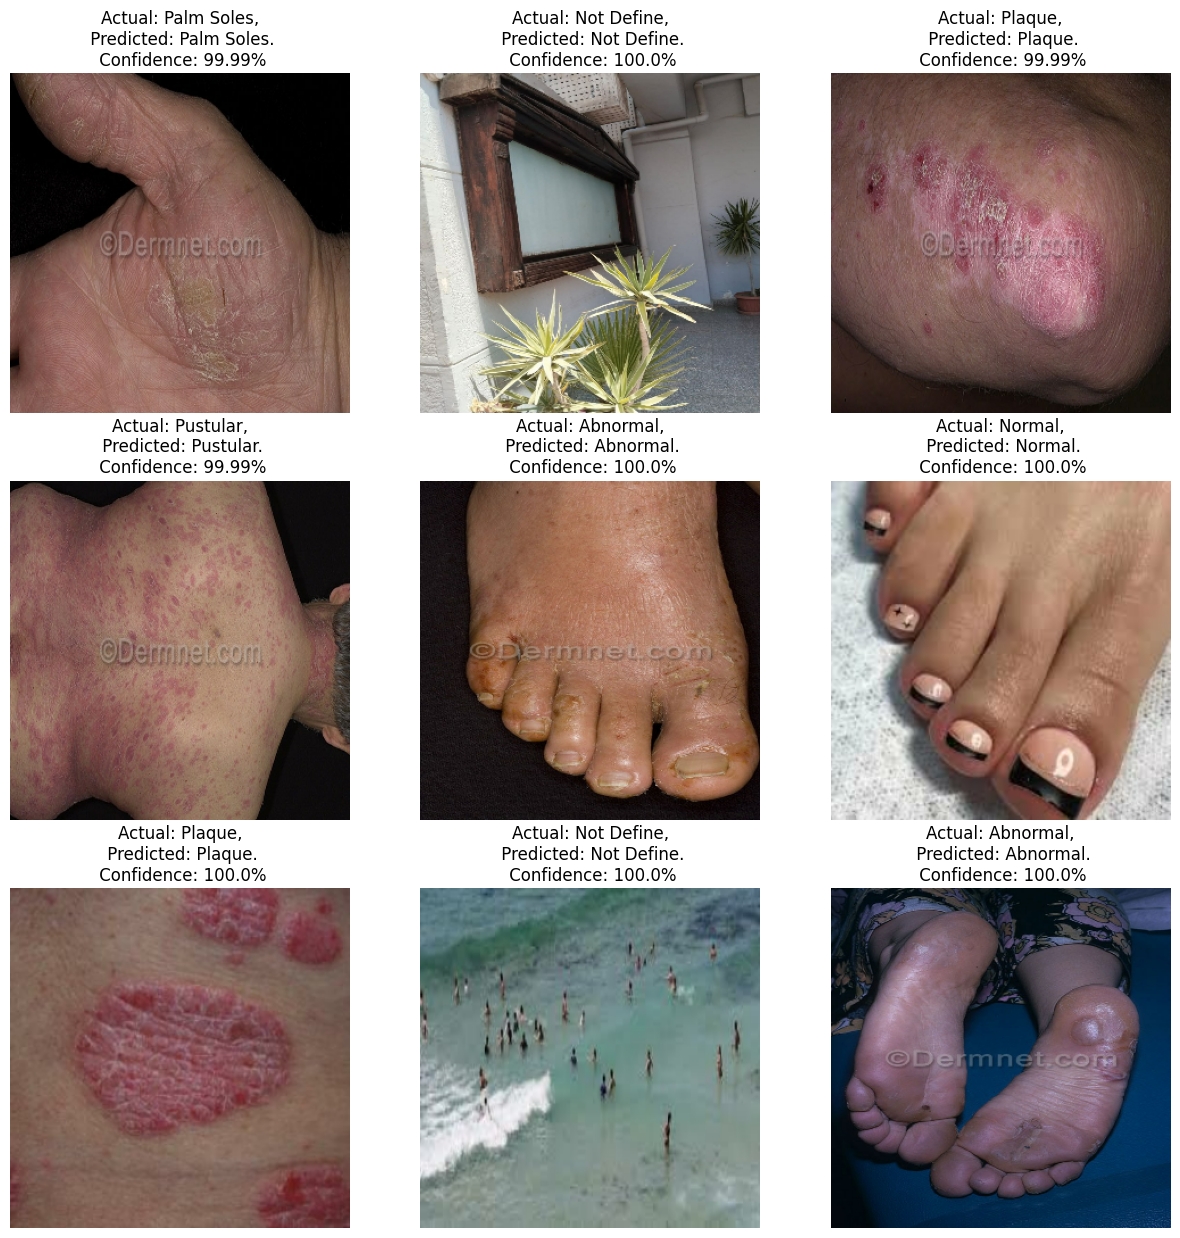

In [43]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


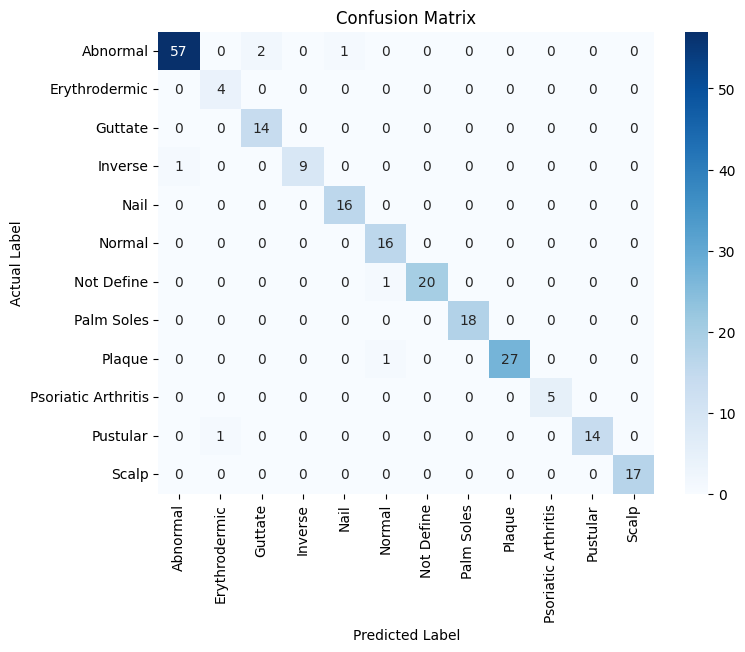

In [44]:
#confusion_matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

y_pred = []
y_true = []
for images, labels in test_ds:
    y_pred.extend(np.argmax(model.predict(images), axis=1))
    y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)
#saving the cm to a .npy file for later use
np.save('cm', cm)

#plotting the confusion matrix using seaborn library
plt.figure(figsize=(8,6))
sns.heatmap(cm , annot=True, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

In [45]:
#classification report

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names))


                     precision    recall  f1-score   support

           Abnormal       0.98      0.95      0.97        60
      Erythrodermic       0.80      1.00      0.89         4
            Guttate       0.88      1.00      0.93        14
            Inverse       1.00      0.90      0.95        10
               Nail       0.94      1.00      0.97        16
             Normal       0.89      1.00      0.94        16
         Not Define       1.00      0.95      0.98        21
         Palm Soles       1.00      1.00      1.00        18
             Plaque       1.00      0.96      0.98        28
Psoriatic Arthritis       1.00      1.00      1.00         5
           Pustular       1.00      0.93      0.97        15
              Scalp       1.00      1.00      1.00        17

           accuracy                           0.97       224
          macro avg       0.96      0.97      0.96       224
       weighted avg       0.97      0.97      0.97       224

